<a href="https://colab.research.google.com/github/Anup2907/salarypredictionportfolio/blob/master/Salarypredictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#My info here
__author__ = "Anup Kumar Chittimalla"
__email__ = "anup.chitts@gmail.com"

#import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import statsmodels.api as sm
from scipy import stats as sts
from statsmodels.stats.diagnostic import het_breuschpagan as bp
from statsmodels.stats.stattools import durbin_watson as dw
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings("ignore")

class Data:
    
    def __init__(self,target_var):
        self.target_var = target_var
    
    def load_file(file):
        '''loads csv to pd dataframe'''
        return pd.read_csv(file)
    
    def consolidate_data(df1, df2, key=None, left_index=False, right_index=False):
        '''perform inner join to return only records that are present in both dataframes'''
        return pd.merge(left=df1, right=df2, on=key, left_index=left_index, right_index=right_index)
    
    def data_info(file, verbose=True):
        '''checks length and dtypes of dataframes'''
        return file.info(verbose=verbose)
    
    def categorical_cols(df):
        '''Identifies categorical data from other datatypes'''
        cat_cols = df.select_dtypes(include = 'O')
        categorical_cols = list(cat_cols.columns.values)
        return categorical_cols
    
    def numerical_cols(df):
        '''Identifies numerical data from other datatypes'''
        num_cols = df.select_dtypes(include = [np.number])
        numerical_cols = list(num_cols.columns.values)
        return numerical_cols
    
    def missing_data(df):
        '''returns missing data percentage in dataframe'''
        return df.isnull().sum()/len(df)*100
             
    def potential_outlier(df):
        '''detects potential outliers using IQR'''
        stat = df[target_var].describe()
        IQR = stat['75%'] - stat['25%']
        upper = stat['75%'] + 1.5 * IQR
        lower = stat['25%'] - 1.5 * IQR
        print("stat:\t {}".format(stat))
        print("-----------------------------------------------------")
        print("IQR:\t {}".format(IQR))
        print("upper:\t {}".format(upper))
        print("lower:\t {}".format(lower))
        print('The upper and lower bounds for suspected outliers are {} and {}.'.format(upper, lower))
    
    def clean_data(raw_df):
        '''remove rows that contain salary <= 8.5 (lower band) or duplicate job IDs'''
        duplicate = raw_df.duplicated().sum()
        clean_df = raw_df.drop_duplicates(subset='jobId')
        print("{} duplicate rows have been removed".format(duplicate))
        lowbandrows = clean_df[clean_df.salary <= 8.5]
        clean_df = clean_df[clean_df.salary > 8.5]
        print("{} rows that contain salary <=8.5 have been removed".format(lowbandrows))
        return clean_df
    
    def obj_to_cat(df):
        '''changing dtype from object to category'''
        columns = ['companyId', 'jobType', 'degree', 'major', 'industry']
        for col in columns:
            df[col] = df[col].astype('category')
        return df.dtypes    
    
    def label_encode(label_df,col):
        '''encode the categories using avg salary for each category to replace label'''
        cat_dict = {}
        cats = label_df[col].cat.categories.tolist()
        for cat in cats:
            cat_dict[cat] = label_df[label_df[col] == cat]['salary'].mean()
        label_df[col] = label_df[col].map(cat_dict)

    def one_hot_encode_feature_df(df, cat_vars=None, num_vars=None):
        '''performs one-hot encoding on all categorical variables and combines result with continous variables'''
        cat_df = pd.get_dummies(df[cat_vars])
        num_df = df[num_vars].apply(pd.to_numeric)
        return pd.concat([cat_df, num_df], axis=1)

class Regr_assump:
    
    def __init__(self,target_var):
        self.target_var = target_var
    
    #target variable normal distribution check            
    def target_dist(df):
        '''visualizing distribution of target variable'''
        plt.figure(figsize = (14,6))
        plt.subplot(1,2,1)
        sns.boxplot(df[target_var])
        plt.subplot(1,2,2)
        sns.distplot(df[target_var], bins=20)
        return plt.show()
    
    #Multicollinearity and linearity check
    def correlation(self,df):
        '''correlations between selected features'''
        plt.figure(figsize=(12,10))
        sns.heatmap(df[self + [target_var]].corr(), cmap = 'coolwarm', annot=True)
        plt.xticks(rotation=45)
        return plt.show() 
    
    def vif(self,df):
        '''checking multicollinearity through VIF value'''
        vif = pd.DataFrame()
        vif["variables"] = df.columns
        vif = [variance_inflation_factor(df[self].values, i) for i in range(df[self].shape[1])]
        return dict(zip(vif["variables"], vif))
        
    #Homoscedasticity check by residual plot and Breusch_Pagan test
    def resid_plot(self,df):
        '''residual plots between numerical features'''
        sns.residplot(x=self, y=target_var, data=df, color='green')
        plt.xlabel(self)
        plt.ylabel(target_var)
        return plt.show()

    def Breusch_Pagan(self,df):
        '''Homoscedasticity test using Breusch_Pagan test'''
        x = df[self]
        y = df[target_var]
        model = sm.OLS(x,y).fit()
        bp_test = bp(model.resid,self)
        labels = ['BP Statistic', 'BP-Test p-value', 'F-Statistic', 'F-Test p-value']
        return dict(zip(labels, bp_test))
    
    #QQ plot
    def QQ_plot(self,df):
         '''Residual normality using QQ plot'''   
         sts.probplot(df[self], dist="norm", plot=plt)
         return plt.show()
    
    #Autocorrelation (Durbin Watson test) and residual normality (Jarque bera test) using OLS summary
    def ols_summ(self,df):
        '''Ordinary least squares summary'''
        X = df[self]
        y = df[target_var]
        X = sm.add_constant(df[self])
        model = sm.OLS(y,X).fit()
        return model.summary()
    
class descrip_stats:
    
    def __init__(self,target_var):
        self.target_var = target_var
        
    def describe(self,df):
        p = df[self].describe()
        return p
    
    #Checking the distributions of numerical variables
    def hist(self,df):
        df[self].hist()
        plt.xlabel(self)
        return plt.show()
    
    #Logarithm transformation 
    def log_transform(self,df):
        temp = df[df[self] != 0]
        temp = temp[self].apply(np.log)
        temp.describe()
        temp.hist()
        plt.xlabel(self)
        return plt.show()
            
    def scatter_plot(self,df):
        '''Checking scatter plot of numeric variables with target variable'''
        plt.scatter(x=self, y=target_var, data=df, alpha=0.1)
        plt.xlabel(self)
        plt.ylabel(target_var)
        return plt.show()
    
    def count_plot(self,df):
        '''count plots of categorical variables'''
        sns.set(style="darkgrid")
        sns.countplot(x=self, data=df)
        plt.xlabel(self)
        plt.xticks(rotation=45)
        print("-------------------------------------------------------------") 
        return plt.show() 
        
    def box_plot(self, df):
        '''box plots of variables with target variable'''
        sns.set(style="darkgrid")
        sns.boxplot(y=target_var, x=self, data=df)
        plt.xticks(rotation=45)
        print("-------------------------------------------------------------") 
        return plt.show() 
        
        
class feat_engg:
    
    def __init__(self, cats_cols, target_var):
        self.cats_cols = cats_cols
        self.target_var = target_var
        
    def group_mean(df):
        '''calculates the salary mean grouping categorical columns'''
        a = df.groupby(cats_cols).mean()
        a = a[target_var].reset_index()
        a.rename({target_var: "group_mean"}, inplace=True, axis=1)
        df = df.merge(a, how = "left", on = cats_cols)
        return df
      
    def group_median(df):
      '''calculates the salary median grouping categorical columns'''
        b = df.groupby(cats_cols).median()
        b = b[target_var].reset_index()
        b.rename({target_var: "group_median"}, inplace=True, axis=1)
        df = df.merge(b, how = "left", on = cats_cols)
        return df
    
    def group_std(df):
      '''calculates the salary standard deviation grouping categorical columns'''
        c = df.groupby(cats_cols).std()
        c = c[target_var].reset_index()
        c.rename({target_var: "group_std"}, inplace=True, axis=1)
        df = df.merge(c, how = "left", on = cats_cols)
        return df
        
    def group_max(df):
      '''calculates the salary maximum grouping categorical columns'''
        d = df.groupby(cats_cols).max()
        d = d[target_var].reset_index()
        d.rename({target_var: "group_max"}, inplace=True, axis=1)
        df = df.merge(d, how = "left", on = cats_cols)
        return df
    
    def group_min(df):
      '''calculates the salary minimum grouping categorical columns'''
        e = df.groupby(cats_cols).min()
        e = e[target_var].reset_index()
        e.rename({target_var: "group_min"}, inplace=True, axis=1)
        df = df.merge(e, how = "left", on = cats_cols)
        return df


In [4]:
if __name__ == '__main__':
  from google.colab import files
  uploaded = files.upload()


Saving test_features.csv to test_features.csv
Saving train_features.csv to train_features.csv
Saving train_salaries.csv to train_salaries.csv


In [5]:
  train_feature_file = 'train_features.csv'
  train_target_file = 'train_salaries.csv'
  test_feature_file = 'test_features.csv'

  #define target variable
  target_var = 'salary'

  #load data
  print("Loading data")
  feature_df = Data.load_file(train_feature_file)
  target_df = Data.load_file(train_target_file)
  test_df = Data.load_file(test_feature_file)

Loading data


In [0]:
  #consolidate training data
  raw_train_df = Data.consolidate_data(feature_df, target_df, key='jobId')
    

In [7]:
  #dataframe length and dtypes 
  Data.data_info(raw_train_df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
salary                 1000000 non-null int64
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


In [8]:
  #identify categorical columns
  cats_cols = Data.categorical_cols(raw_train_df)
  cats_cols.remove('jobId')
  print(cats_cols)  

['companyId', 'jobType', 'degree', 'major', 'industry']


In [9]:
  #identify numerical columns
  nums_cols = Data.numerical_cols(raw_train_df)
  print(nums_cols)

['yearsExperience', 'milesFromMetropolis', 'salary']


In [10]:
  #check missing value percentage
  Data.missing_data(raw_train_df)
    

jobId                  0.0
companyId              0.0
jobType                0.0
degree                 0.0
major                  0.0
industry               0.0
yearsExperience        0.0
milesFromMetropolis    0.0
salary                 0.0
dtype: float64

In [11]:
  #check potential outliers
  Data.potential_outlier(raw_train_df)

stat:	 count    1000000.000000
mean         116.061818
std           38.717936
min            0.000000
25%           88.000000
50%          114.000000
75%          141.000000
max          301.000000
Name: salary, dtype: float64
-----------------------------------------------------
IQR:	 53.0
upper:	 220.5
lower:	 8.5
The upper and lower bounds for suspected outliers are 220.5 and 8.5.


In [12]:
  #cleaning the data, removing records below lower band
  clean_df = Data.clean_data(raw_train_df)

0 duplicate rows have been removed
                   jobId companyId  ... milesFromMetropolis salary
30559   JOB1362684438246    COMP44  ...                   7      0
495984  JOB1362684903671    COMP34  ...                  25      0
652076  JOB1362685059763    COMP25  ...                  60      0
816129  JOB1362685223816    COMP42  ...                   6      0
828156  JOB1362685235843    COMP40  ...                  29      0

[5 rows x 9 columns] rows that contain salary <=8.5 have been removed


In [13]:
  #changing dtype from object to category
  Data.obj_to_cat(clean_df)

jobId                    object
companyId              category
jobType                category
degree                 category
major                  category
industry               category
yearsExperience           int64
milesFromMetropolis       int64
salary                    int64
dtype: object

In [0]:
  #label encoding  with mean salary to check the correlations
  label_df = clean_df.copy()
  for col in label_df.columns:
      if label_df[col].dtype.name == 'category':
          Data.label_encode(label_df,col)

In [15]:
  label_df.head(5)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,115.345049,135.458547,130.505647,133.322042,115.735540,10,83,130
1,JOB1362684407688,115.756548,145.311425,101.921085,102.583864,121.645362,3,73,101
2,JOB1362684407689,116.224249,125.368630,135.490979,130.372436,115.735540,10,38,137
3,JOB1362684407690,116.199380,115.368518,135.490979,129.072085,109.435222,8,17,142
4,JOB1362684407691,115.888501,125.368630,125.454663,130.372436,130.747659,8,16,163


In [16]:
  label_df.dtypes

jobId                    object
companyId              category
jobType                category
degree                 category
major                  category
industry               category
yearsExperience           int64
milesFromMetropolis       int64
salary                    int64
dtype: object

In [17]:
#converting the datatypes to int to get correlation matrix
for v in cats_cols:
  label_df[v] = label_df[v].astype(int)
label_df.dtypes



jobId                  object
companyId               int64
jobType                 int64
degree                  int64
major                   int64
industry                int64
yearsExperience         int64
milesFromMetropolis     int64
salary                  int64
dtype: object

#Regression Assumptions


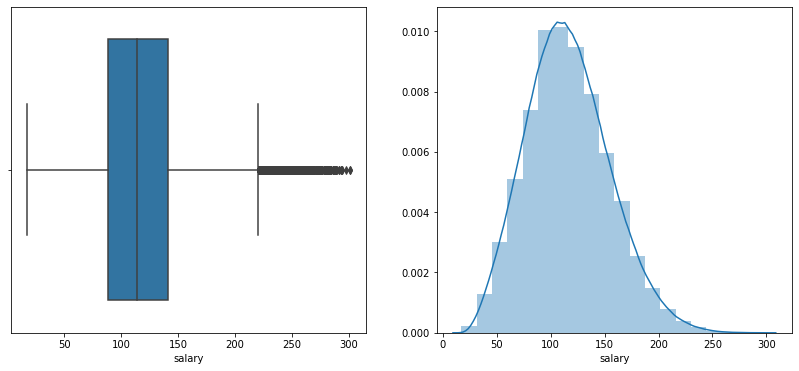

In [18]:
    #target variable distribution
    Regr_assump.target_dist(clean_df)

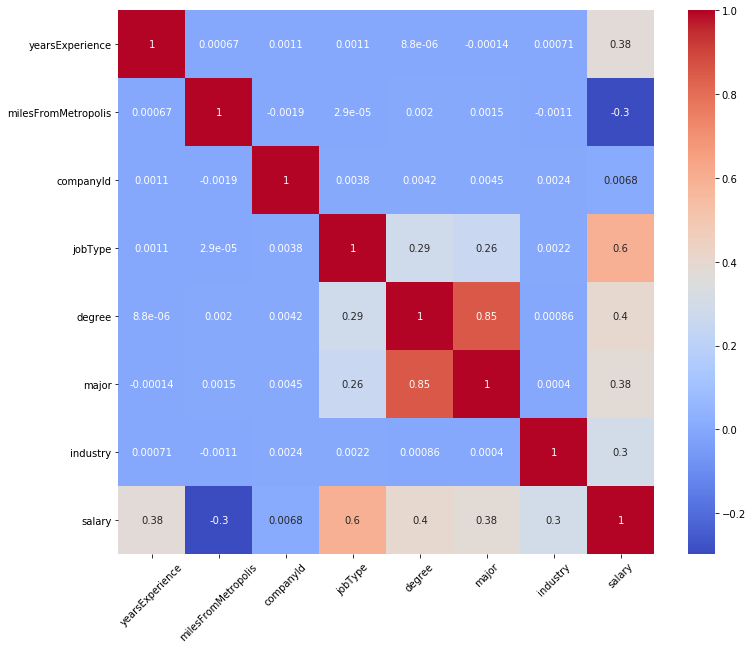

In [19]:
    #correlation matrix using heatmap
    features = ['yearsExperience', 'milesFromMetropolis','companyId', 
                'jobType', 'degree', 'major', 'industry']
    Regr_assump.correlation(features,label_df) 

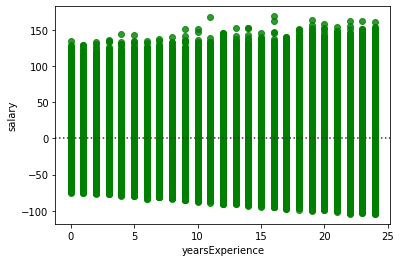

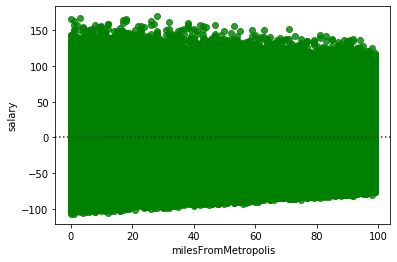

In [23]:
    #Residual plot to check homoschedasticity
    Regr_assump.resid_plot('yearsExperience',clean_df)
    Regr_assump.resid_plot('milesFromMetropolis',clean_df)
    

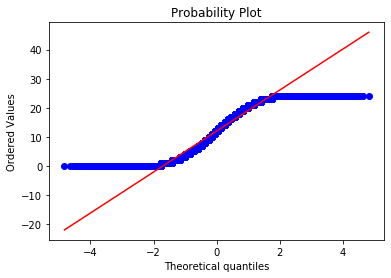

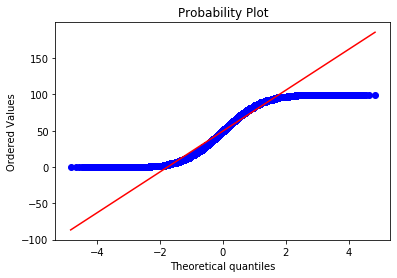

In [24]:
    #Probability plots for residual normality
    Regr_assump.QQ_plot('yearsExperience',clean_df)
    Regr_assump.QQ_plot('milesFromMetropolis',clean_df) 

In [25]:
    #OLS summary
    Regr_assump.ols_summ('yearsExperience',clean_df)
    

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                 1.636e+05
Date:                Tue, 11 Feb 2020   Prob (F-statistic):               0.00
Time:                        03:24:21   Log-Likelihood:            -4.9994e+06
No. Observations:              999995   AIC:                         9.999e+06
Df Residuals:                  999993   BIC:                         9.999e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              91.9202      0.070   1319.926      0.000      91.784      92.057
yearsExperience     2.0131      0.005    404.535      0.000       2.003       2.023
==============================================================================
Omnibus:                    12736.820   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13056.200
Skew:                           0.272   Prob(JB):                         0.00
Kurtosis:                       2.867   Cond. No.                         27.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
Regr_assump.ols_summ('milesFromMetropolis',clean_df)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                 9.723e+04
Date:                Tue, 11 Feb 2020   Prob (F-statistic):               0.00
Time:                        03:24:25   Log-Likelihood:            -5.0288e+06
No. Observations:              999995   AIC:                         1.006e+07
Df Residuals:                  999993   BIC:                         1.006e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 135.8304      0.073   1850.969      0.000     135.687     135.974
milesFromMetropolis    -0.3991      0.001   -311.822      0.000      -0.402      -0.397
==============================================================================
Omnibus:                    12588.061   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12968.720
Skew:                           0.274   Prob(JB):                         0.00
Kurtosis:                       2.891   Cond. No.                         114.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

There is clear multicollinearity between "Degree and Major". And from the QQ_plots it is evident that residuals are not normal. Hence two assumptions of Linear Regression are failed.

#Descriptive Statistics


In [27]:
  #Describe numerical columns
  descrip_stats.describe('yearsExperience',clean_df)
  

count    999995.000000
mean         11.992407
std           7.212390
min           0.000000
25%           6.000000
50%          12.000000
75%          18.000000
max          24.000000
Name: yearsExperience, dtype: float64

In [28]:
  descrip_stats.describe('milesFromMetropolis',clean_df)

count    999995.000000
mean         49.529381
std          28.877721
min           0.000000
25%          25.000000
50%          50.000000
75%          75.000000
max          99.000000
Name: milesFromMetropolis, dtype: float64

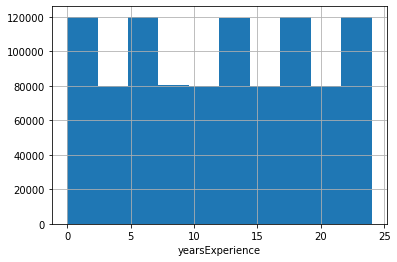

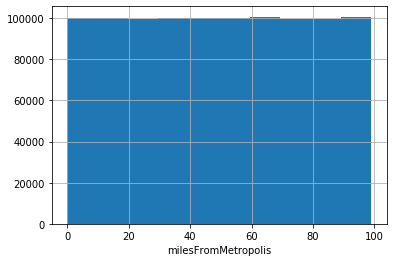

In [29]:
  #Histogram for numerical columns
  descrip_stats.hist('yearsExperience',clean_df)
  descrip_stats.hist('milesFromMetropolis',clean_df)

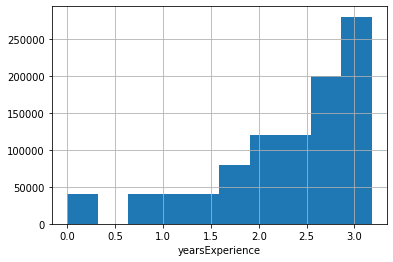

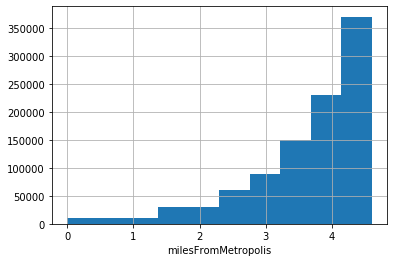

In [30]:
  #Plotting log transform of variables just to check how distribution is getting changed
  descrip_stats.log_transform('yearsExperience',clean_df)
  descrip_stats.log_transform('milesFromMetropolis',clean_df)

As the metric is distance, the distributions need not be normals, hence considering original numeric variables

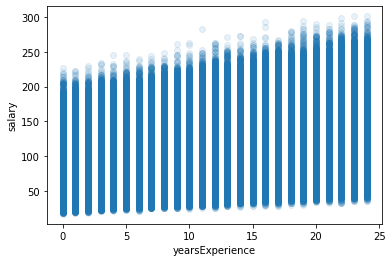

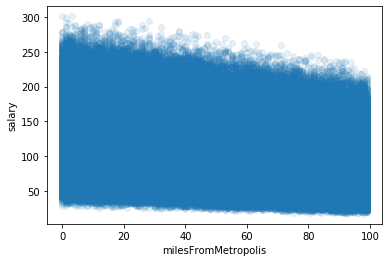

In [31]:
  #scatter plots of numerical variables with target variable
  descrip_stats.scatter_plot('yearsExperience',clean_df)
  descrip_stats.scatter_plot('milesFromMetropolis',clean_df)

-------------------------------------------------------------


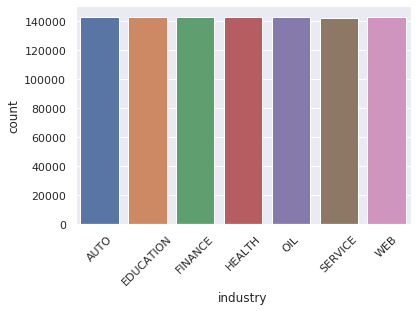

-------------------------------------------------------------


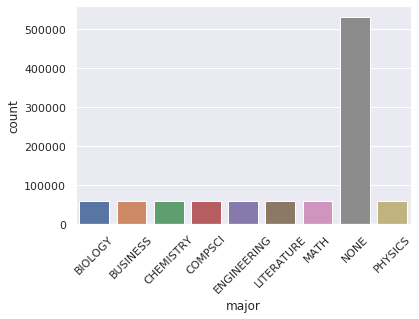

-------------------------------------------------------------


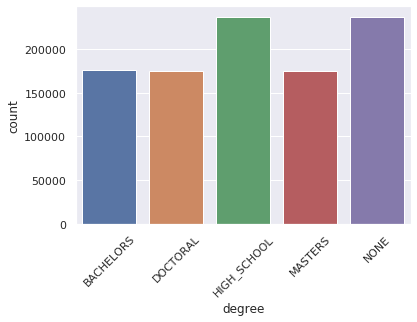

-------------------------------------------------------------


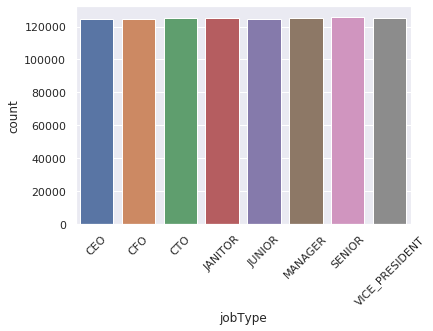

In [32]:
  #count plots of selected variables
  features = ['industry','major','degree','jobType']
  for feat in features:
      descrip_stats.count_plot(feat,clean_df)

-------------------------------------------------------------


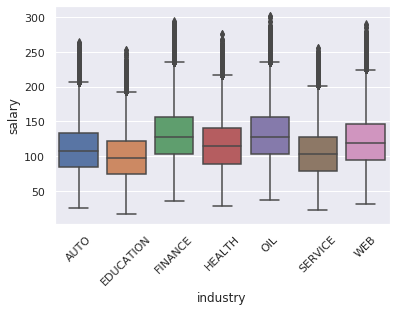

-------------------------------------------------------------


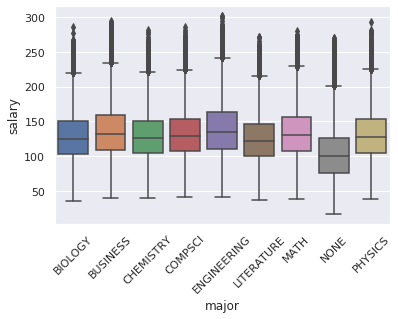

-------------------------------------------------------------


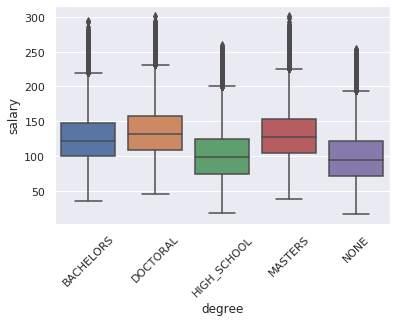

-------------------------------------------------------------


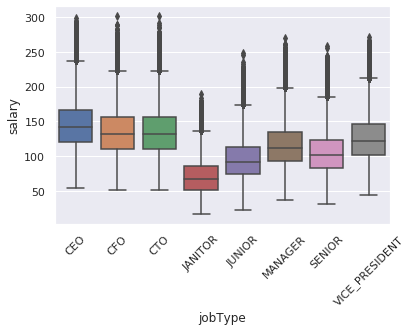

In [33]:
  #box plots of selected variables
  features = ['industry','major','degree','jobType']
  for var in features:
      descrip_stats.box_plot(var,clean_df)

#Feature Engineering


In [0]:
  #Creating new features such as mean, median, std, max, min
  clean_mean = feat_engg.group_mean(clean_df)
  clean_med_mean = feat_engg.group_median(clean_mean)
  clean_med_mean_std = feat_engg.group_std(clean_med_mean)  
  clean_med_mean_std_max = feat_engg.group_max(clean_med_mean_std)  
  clean_feats = feat_engg.group_min(clean_med_mean_std_max)

In [22]:
  Data.data_info(clean_feats)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999995 entries, 0 to 999994
Data columns (total 14 columns):
jobId                  999995 non-null object
companyId              999995 non-null category
jobType                999995 non-null category
degree                 999995 non-null category
major                  999995 non-null category
industry               999995 non-null category
yearsExperience        999995 non-null int64
milesFromMetropolis    999995 non-null int64
salary                 999995 non-null int64
group_mean             999995 non-null float64
group_median           999995 non-null float64
group_std              999074 non-null float64
group_max              999995 non-null float64
group_min              999995 non-null float64
dtypes: category(5), float64(5), int64(3), object(1)
memory usage: 81.1+ MB


In [32]:
  #checking missing data percentage from the newly created features
  Data.missing_data(clean_feats)

jobId                  0.0
companyId              0.0
jobType                0.0
degree                 0.0
major                  0.0
industry               0.0
yearsExperience        0.0
milesFromMetropolis    0.0
salary                 0.0
group_mean             0.0
group_median           0.0
group_std              0.0
group_max              0.0
group_min              0.0
dtype: float64

In [25]:
  #imputing missing values of standard deviation with 0 as the percentage is very small
  clean_feats['group_std'] = clean_feats['group_std'].fillna(0)
  Data.missing_data(clean_feats)

jobId                  0.0
companyId              0.0
jobType                0.0
degree                 0.0
major                  0.0
industry               0.0
yearsExperience        0.0
milesFromMetropolis    0.0
salary                 0.0
group_mean             0.0
group_median           0.0
group_std              0.0
group_max              0.0
group_min              0.0
dtype: float64

In [26]:
clean_feats.head(5)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary,group_mean,group_median,group_std,group_max,group_min
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130,130.875000,136.0,19.555324,150.0,98.0
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101,138.031250,132.0,29.306248,204.0,90.0
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137,142.000000,137.0,28.827071,173.0,116.0
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142,129.000000,131.0,29.251781,169.0,77.0
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163,153.583333,141.5,46.310137,232.0,94.0


In [27]:
  #Label Encoding new dataframe after feature engineering
  for col in cats_cols:
      le = preprocessing.LabelEncoder()
      clean_feats[col] = le.fit_transform(clean_feats[col].astype(str))
      clean_feats[col] = clean_feats[col].astype('category')
  clean_feats.head(5) 

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary,group_mean,group_median,group_std,group_max,group_min
0,JOB1362684407687,31,1,3,6,3,10,83,130,130.875000,136.0,19.555324,150.0,98.0
1,JOB1362684407688,11,0,2,7,6,3,73,101,138.031250,132.0,29.306248,204.0,90.0
2,JOB1362684407689,48,7,1,8,3,10,38,137,142.000000,137.0,28.827071,173.0,116.0
3,JOB1362684407690,32,5,1,2,0,8,17,142,129.000000,131.0,29.251781,169.0,77.0
4,JOB1362684407691,60,7,0,8,2,8,16,163,153.583333,141.5,46.310137,232.0,94.0


In [28]:
clean_feats.dtypes

jobId                    object
companyId              category
jobType                category
degree                 category
major                  category
industry               category
yearsExperience           int64
milesFromMetropolis       int64
salary                    int64
group_mean              float64
group_median            float64
group_std               float64
group_max               float64
group_min               float64
dtype: object

#Model building

In [0]:
  #Splitting the dependent and independent variables
  X = pd.DataFrame(clean_feats.drop(columns=['salary','jobId']))
  y = pd.DataFrame(clean_feats['salary'], index=None)


In [0]:
  #Splitting the dataset into the Training set and Test set
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                            random_state = 77)

In [31]:
  #Random Forest Regressor with GridsearchCV
  param_grid = [{'n_estimators' : [3,10,30], 'max_features' : [2,4,6,8]},
                {'bootstrap' : [False], 'n_estimators' : [3,10], 'max_features' : [2,3,4]},]
  rf = RandomForestRegressor()
  grid_srch = GridSearchCV(rf, param_grid, cv=5, scoring = 'neg_mean_squared_error')
  grid_srch.fit(X_train, y_train)
  grid_srch.best_params_
  grid_srch.best_estimator_
  cvres = grid_srch.cv_results_
  for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

21.623521849071945 {'max_features': 2, 'n_estimators': 3}
19.59163383625235 {'max_features': 2, 'n_estimators': 10}
18.9923045746165 {'max_features': 2, 'n_estimators': 30}
21.05265052791329 {'max_features': 4, 'n_estimators': 3}
19.161204962534867 {'max_features': 4, 'n_estimators': 10}
18.576993281090267 {'max_features': 4, 'n_estimators': 30}
20.962067526259904 {'max_features': 6, 'n_estimators': 3}
19.090113730983393 {'max_features': 6, 'n_estimators': 10}
18.51501962248243 {'max_features': 6, 'n_estimators': 30}
20.946401857663474 {'max_features': 8, 'n_estimators': 3}
19.09846187800714 {'max_features': 8, 'n_estimators': 10}
18.51386392651328 {'max_features': 8, 'n_estimators': 30}
21.97038216373574 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
20.175547893623037 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
21.47277963491256 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
19.763250602385654 {'bootstrap': False, 'max_features': 3, 'n_estimato

In [35]:
final_model = grid_srch.best_estimator_
final_predictions = final_model.predict(X_test)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

18.53916446794888